In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [2]:
import hashlib

In [3]:
import networkx as nx
import igraph as ig
import itertools
import hashlib

In [4]:
import networkx as nx
import hashlib
import itertools
from collections import defaultdict

import networkx as nx
import itertools
from collections import defaultdict
import hashlib

import networkx as nx
import itertools

일단은 ChatGPT 예제는 잘 작도암. 우리가 사용하는 그래프에 대해서 확인해보기

아래 부분부터 잘되는거 시작. 위 코드들은 다시 weighted bigraph의 canonical form을 구하기 위해서 다양한 시도를 하는 부분

In [5]:
def improved_EPM_bipartite_graph_generator(num_system, num_ancilla, type):
    """
    개선된 EPM 이분 그래프 생성기
    
    Parameters:
    -----------
    num_system : int
        시스템 노드 수
    num_ancilla : int
        앵커라 노드 수
    type : int
        그래프 유형
        
    Yields:
    -------
    nx.Graph
        생성된 이분 그래프
    """
    import networkx as nx
    import itertools
    
    num_total = num_system + num_ancilla
    
    # red-blue 조합 생성 (list_all_combinations_with_duplication 함수 필요)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)
    
    # ancilla 조합 생성 (generate_combinations 함수 필요)
    if num_ancilla > 0:
        ancilla_combinations_pre = generate_combinations(num_total)
        ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))
    
    for rb_comb in red_blue_combinations:
        if num_ancilla > 0:
            for bl_comb in ancilla_combinations:
                # 바로 최종 레이블로 노드 생성
                B = nx.Graph()
                
                # 시스템 노드 추가 (S_0, S_1, ...)
                system_nodes = [f'S_{i}' for i in range(num_system)]
                B.add_nodes_from(system_nodes, category='system_nodes', bipartite=0)
                
                # 앵커라 노드 추가 (A_0, A_1, ...)
                ancilla_nodes = [f'A_{i}' for i in range(num_ancilla)]
                B.add_nodes_from(ancilla_nodes, category='ancilla_nodes', bipartite=0)
                
                # 스컬프팅 노드 추가 (0, 1, 2, ...)
                sculpting_nodes = list(range(num_total))
                B.add_nodes_from(sculpting_nodes, category='sculpting_nodes', bipartite=1)
                
                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = vt[0]  # 스컬프팅 노드 인덱스
                    blue = vt[1]  # 스컬프팅 노드 인덱스
                    system_node = f'S_{rb_index}'
                    B.add_edge(system_node, red, weight=1.0)
                    B.add_edge(system_node, blue, weight=2.0)
                
                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    ancilla_node = f'A_{anc_index}'
                    for vt_inx in vt_list:
                        B.add_edge(ancilla_node, vt_inx, weight=3.0)
                
                # 모든 노드가 적어도 2개의 이웃을 갖는지 확인
                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    yield B
        else:  # num_ancilla == 0 인 경우
            # 바로 최종 레이블로 노드 생성
            B = nx.Graph()
            
            # 시스템 노드 추가 (S_0, S_1, ...)
            system_nodes = [f'S_{i}' for i in range(num_system)]
            B.add_nodes_from(system_nodes, category='system_nodes', bipartite=0)
            
            # 스컬프팅 노드 추가 (0, 1, 2, ...)
            sculpting_nodes = list(range(num_total))
            B.add_nodes_from(sculpting_nodes, category='sculpting_nodes', bipartite=1)
            
            # red-blue 엣지 추가
            for rb_index, vt in enumerate(rb_comb):
                red = vt[0]  # 스컬프팅 노드 인덱스
                blue = vt[1]  # 스컬프팅 노드 인덱스
                system_node = f'S_{rb_index}'
                B.add_edge(system_node, red, weight=1.0)
                B.add_edge(system_node, blue, weight=2.0)
            
            # 모든 노드가 적어도 2개의 이웃을 갖는지 확인
            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                yield B

def get_ordered_nodes(G):
    system_nodes = sorted([n for n, attr in G.nodes(data=True) if attr.get('category') == 'system_nodes'])
    ancilla_nodes = sorted([n for n, attr in G.nodes(data=True) if attr.get('category') == 'ancilla_nodes'])
    sculpting_nodes = sorted([n for n, attr in G.nodes(data=True) if attr.get('category') == 'sculpting_nodes'], 
                            key=lambda x: int(x) if isinstance(x, (int, float)) or x.isdigit() else x)
    return system_nodes + ancilla_nodes + sculpting_nodes

In [6]:
def get_adjacency_matrices(B, nodelist=None):
    """
    주어진 이분 그래프에서 가중치가 적용된 인접 행렬을 반환합니다.
    
    Parameters:
    B (nx.Graph): 입력 이분 그래프
    nodelist (list, optional): 특정 순서로 정렬된 노드 리스트. 제공되지 않으면 기본 정렬 사용.
    
    Returns:
    numpy.ndarray: 가중치가 적용된 인접 행렬
    """
    if nodelist is None:
        # 카테고리별로 노드 분리
        system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
        ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
        sculpting_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'sculpting_nodes']
        
        # 원하는 순서로 노드 결합
        nodelist = system_nodes + ancilla_nodes + sculpting_nodes
    
    # 가중치가 적용된 인접 행렬
    weighted_adj_matrix = nx.to_numpy_array(B, nodelist=nodelist, weight='weight')
    return weighted_adj_matrix

In [7]:
import networkx as nx
import igraph as ig
import hashlib
import itertools

# def EPM_bipartite_graph_generator(num_system, num_ancilla, type): 
#     num_total = num_system + num_ancilla

#     # red-blue 조합 생성 (type=0 가정)
#     red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

#     # ancilla 조합 생성
#     ancilla_combinations_pre = generate_combinations(num_total)
#     ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

#     for rb_comb in red_blue_combinations:
#         if num_ancilla != 0:
#             for bl_comb in ancilla_combinations:
#                 B = nx.Graph()
#                 B.add_nodes_from(range(2 * num_total))
#                 mapping = {}

#                 # red-blue 엣지 추가
#                 for rb_index, vt in enumerate(rb_comb):
#                     red = num_total + vt[0]
#                     blue = num_total + vt[1]
#                     B.add_edge(rb_index, red, weight=1.0)
#                     B.add_edge(rb_index, blue, weight=2.0)
#                     mapping[rb_index] = 'S_' + str(rb_index)
#                     mapping[num_total + rb_index] = rb_index

#                 # ancilla 엣지 추가
#                 for anc_index, vt_list in enumerate(bl_comb):
#                     for vt_inx in vt_list:
#                         B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 
#                     mapping[num_system + anc_index] = 'A_' + str(anc_index)
#                     mapping[num_total + num_system + anc_index] = num_system + anc_index

#                 # 노드 속성 추가 (relabel_nodes() 실행 전)
#                 for node_index in range(2 * num_total):
#                     if node_index < num_system:
#                         B.nodes[node_index]['category'] = 'system_nodes'
#                         B.nodes[node_index]['bipartite'] = 0
#                     elif node_index < num_total:
#                         B.nodes[node_index]['category'] = 'ancilla_nodes'
#                         B.nodes[node_index]['bipartite'] = 0
#                     else:
#                         B.nodes[node_index]['category'] = 'sculpting_nodes'
#                         B.nodes[node_index]['bipartite'] = 1

#                 # 노드 속성 저장
#                 node_attributes = {}
#                 for node in B.nodes():
#                     node_attributes[node] = dict(B.nodes[node])
                
#                 # 노드 이름 변경
#                 B = nx.relabel_nodes(B, mapping, copy=False)  
                
#                 # 속성 재적용
#                 for node, new_label in mapping.items():
#                     if new_label in B.nodes and node in node_attributes:
#                         for attr, value in node_attributes[node].items():
#                             B.nodes[new_label][attr] = value

#                 if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
#                     yield B
#         else:
#             B = nx.Graph()
#             B.add_nodes_from(range(2 * num_total))
#             mapping = {}

#             for rb_index, vt in enumerate(rb_comb):
#                 red = num_total + vt[0]
#                 blue = num_total + vt[1]
#                 B.add_edge(rb_index, red, weight=1.0)
#                 B.add_edge(rb_index, blue, weight=2.0)
#                 mapping[rb_index] = 'S_' + str(rb_index)
#                 mapping[num_total + rb_index] = rb_index

#             # 노드 속성 추가 (relabel_nodes() 실행 전)
#             for node_index in range(2 * num_total):
#                 if node_index < num_system:
#                     B.nodes[node_index]['category'] = 'system_nodes'
#                     B.nodes[node_index]['bipartite'] = 0
#                 elif node_index < num_total:
#                     B.nodes[node_index]['category'] = 'ancilla_nodes'
#                     B.nodes[node_index]['bipartite'] = 0
#                 else:
#                     B.nodes[node_index]['category'] = 'sculpting_nodes'
#                     B.nodes[node_index]['bipartite'] = 1

#             # 노드 속성 저장
#             node_attributes = {}
#             for node in B.nodes():
#                 node_attributes[node] = dict(B.nodes[node])

#             # 레이블 변경
#             B = nx.relabel_nodes(B, mapping, copy=False)

#             # 속성 재적용
#             for node, new_label in mapping.items():
#                 if new_label in B.nodes and node in node_attributes:
#                     for attr, value in node_attributes[node].items():
#                         B.nodes[new_label][attr] = value

#             if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
#                 yield B

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}
    # 엣지 추출
    edges = []
    for u, v in nx_graph.edges():
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가
    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    return ig_graph

# Canonical Form 생성 (가중치를 고려하지 않음)
def canonical_form_without_weights(ig_graph):
    # iGraph의 canonical_permutation을 사용하여 가중치 없이 처리
    perm = ig_graph.canonical_permutation()  # 색상(color) 정보 없이 permutation 생성
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환

# Canonical Form의 해시 생성
def generate_hash_from_canonical_form(canonical_form):
    # Canonical Form을 문자열로 변환한 뒤 해시값 생성
    canonical_str = str(canonical_form)
    return hashlib.sha256(canonical_str.encode('utf-8')).hexdigest()

# 그래프 리스트 처리 및 그룹화
def process_and_group_by_canonical_form(graph_list):
    canonical_groups = {}  # 해시 값을 키로, 그래프 그룹을 값으로 저장
    for graph in graph_list:
        # NetworkX -> iGraph 변환
        ig_graph = nx_to_igraph(graph)
        # Canonical Form 생성 (가중치 고려 안 함)
        canonical_form = canonical_form_without_weights(ig_graph)
        # Canonical Form의 해시 생성
        canonical_hash = generate_hash_from_canonical_form(canonical_form)
        # 동일 해시 값끼리 그룹화
        if canonical_hash not in canonical_groups:
            canonical_groups[canonical_hash] = []  # 새로운 그룹 생성
        canonical_groups[canonical_hash].append(graph)  # 그래프 추가
    return canonical_groups  # 그룹화된 결과 반환

def is_single_scc(graph):
    sccs = list(nx.strongly_connected_components(graph))
    return len(sccs) == 1 and len(sccs[0]) == len(graph)

def EPM_digraph_from_EPM_bipartite_graph(B):
    """
    Convert an EPM bipartite graph (B) to a directed graph (D).
    """
    # Initialize directed graph
    D = nx.DiGraph()
    # Identify system and ancilla nodes
    system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla
    # 정수와 문자열을 분리하여 정렬한 후 결합
    sorted_nodes = sorted([node for node in B.nodes if isinstance(node, int)]) + \
        sorted([node for node in B.nodes if isinstance(node, str)])
    # get_adjacency_matrices()에 정렬된 노드 리스트 전달



    adj_weight_matrix_B = get_adjacency_matrices(B, nodelist=sorted_nodes)
    #adj_weight_matrix_B =  get_ordered_adjacency_matrix(B)


    # Extract relevant submatrices for the directed graph
    adj_weight_matrix_D = adj_weight_matrix_B[:num_total, num_total:]
    # Add nodes to directed graph
    D.add_nodes_from(range(num_total))
    # Add directed edges with weights
    for i in range(num_total):
        for j in range(num_total):
            if adj_weight_matrix_D[i, j] != 0:
                D.add_edge(j, i, weight=adj_weight_matrix_D[i, j])  # Reverse direction
    # Map node labels and categories
    mapping = {}
    for i in range(num_total):
        if i < num_system:
            mapping[i] = 'S_' + str(i)
            D.nodes[i]['category'] = 'system_nodes'
        else:
            mapping[i] = 'A_' + str(i - num_system)
            D.nodes[i]['category'] = 'ancilla_nodes'
    # Relabel node
    D = nx.relabel_nodes(D, mapping)
    return D

In [16]:
def filter_groups_by_scc(grouped_graphs):
    """
    SCC 조건을 만족하는 그래프 그룹만 필터링합니다.
    그룹 구조(해시 키)를 유지합니다.
    
    Parameters:
    grouped_graphs (dict): 해시 키와 그래프 리스트를 포함하는 딕셔너리
    
    Returns:
    dict: SCC 조건을 만족하는 그래프 그룹만 포함하는 딕셔너리
    """
    filtered_groups = {}
    
    for key, graph_list in grouped_graphs.items():
        if len(graph_list) > 0:
            try:
                first_graph = graph_list[0]  # 첫 번째 그래프로 SCC 확인
                D = EPM_digraph_from_EPM_bipartite_graph(first_graph)
                if is_single_scc(D):
                    filtered_groups[key] = graph_list  # 그룹 전체를 유지
            except Exception as e:
                print(f"Error processing graph with key {key}: {e}")
                continue
    
    return filtered_groups

# 중복 제거 함수 - 그룹 구조 유지
def extract_unique_bigraphs_with_weights(filtered_groups):
    """
    가중치를 고려하여 각 그룹 내에서 고유한 이분 그래프만 추출합니다.
    그룹 구조(해시 키)를 유지합니다.
    
    Parameters:
    filtered_groups (dict): 해시 키와 그래프 리스트를 포함하는 딕셔너리
    
    Returns:
    dict: 해시 키와 고유 그래프 리스트를 포함하는 딕셔너리
    """
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
    unique_graphs_dict = {}
    
    # 각 그룹 내에서 고유한 그래프 찾기
    for key, graph_list in filtered_groups.items():
        group_unique_graphs = []
        
        for new_graph in graph_list:
            is_unique = True
            
            # 이미 찾은 그룹 내 고유 그래프와 비교
            for existing_graph in group_unique_graphs:
                if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
                    is_unique = False
                    break
            
            if is_unique:
                group_unique_graphs.append(new_graph)
        
        # 최종 결과 딕셔너리에 그룹 추가
        if group_unique_graphs:  # 빈 리스트가 아니면 추가
            unique_graphs_dict[key] = group_unique_graphs
    
    return unique_graphs_dict

# 전체 파이프라인 메인 함수 - 딕셔너리 반환 버전
def generate_unique_epm_graphs_dict(num_system, num_ancilla, type=0):
    """
    고유한 EPM 그래프를 생성하고 해시 키를 유지한 딕셔너리를 반환하는 전체 파이프라인
    """
    # 1. 그래프 생성 (제너레이터)
    #graph_generator = EPM_bipartite_graph_generator(num_system, num_ancilla, type)
    graph_generator =  improved_EPM_bipartite_graph_generator(num_system, num_ancilla, type)
    
    # 2. Canonical Form으로 그룹화
    canonical_groups = process_and_group_by_canonical_form(graph_generator)
    #print(canonical_groups)
    
    # 3. SCC 조건으로 필터링 (그룹 정보 유지)
    filtered_groups = filter_groups_by_scc(canonical_groups)
    
    # 4. 가중치 기반 중복 제거 (그룹 구조 유지)
    unique_graphs_dict = extract_unique_bigraphs_with_weights(filtered_groups)
    
    return unique_graphs_dict, filtered_groups

In [20]:
unique_graphs_gen, canonical_groups = generate_unique_epm_graphs_dict(3, 1)
unique_graphs_list = list(unique_graphs_gen)

In [28]:
unique_graphs_gen.keys()

dict_keys(['7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0', '7557ff98f0fb1f45bff4842b435377aa9662820516e3f21f50807ee05670ab2e', '36019ea344ba82e088903dc9c14930cdd02310afc42538024b1a6bc35a3336ac', '218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8', 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a', '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d', 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d', '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac'])

In [21]:
canonical_groups

{'7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0': [<networkx.classes.graph.Graph at 0x1314cebd0>,
 '7557ff98f0fb1f45bff4842b435377aa9662820516e3f21f50807ee05670ab2e': [<networkx.classes.graph.Graph at 0x1314cfb10>,
 '36019ea344ba82e088903dc9c14930cdd02310afc42538024b1a6bc35a3336ac': [<networkx.classes.graph.Graph at 0x1314ce890>,
 '218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<networkx.classes.graph.Graph at 0x1314e4150>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<networkx.classes.graph.Graph at 0x1314dfc10>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<networkx.classes.graph.Graph at 0x1314e4f90>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<networkx.classes.graph.Graph at 0x1314e5990>,
  ...],
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<networkx.classes.graph.Graph at 0x1314dcf10>,
  <networkx.classes.graph.Graph at 0x137e826d0>]}

In [22]:
total_elements = sum(len(v) for v in canonical_groups.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

3264


In [23]:
canonical_groups[list(canonical_groups.keys())[0]][0]

In [24]:
list(canonical_groups.keys())[0]

'7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0'

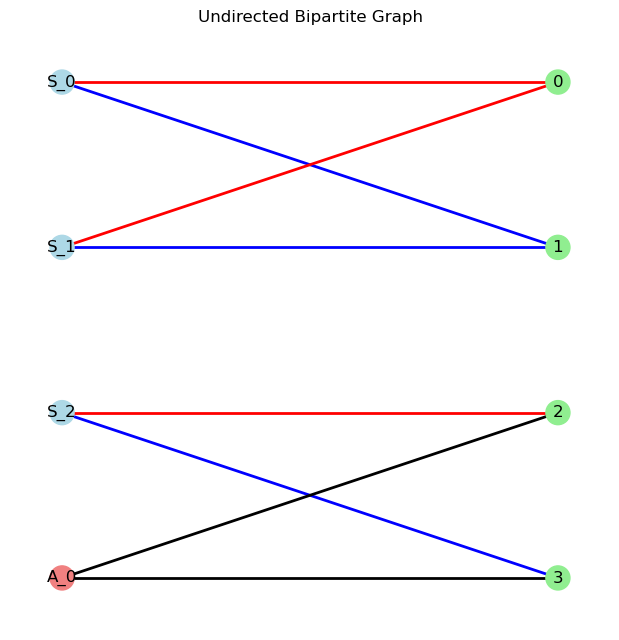

In [25]:
Draw_EPM_bipartite_graph(canonical_groups[list(canonical_groups.keys())[0]][0])

In [26]:
# Get adjacency matrix as a NumPy array
adj_matrix = nx.to_numpy_array(canonical_groups[list(canonical_groups.keys())[0]][0])
print(adj_matrix)

[[0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2.]
 [0. 0. 0. 0. 0. 0. 3. 3.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 3. 0. 0. 0. 0.]
 [0. 0. 2. 3. 0. 0. 0. 0.]]


In [30]:
total_elements = sum(len(v) for v in unique_graphs_gen.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

31
